In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import textblob
import sklearn
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [4]:
df=pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [5]:
df.iloc[0].review

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [6]:
df.iloc[3].review

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

In [7]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [8]:
df.shape

(50000, 2)

In [9]:
df.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [10]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [11]:
#checking for null values
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [12]:
#lowercasing
df.review=df.review.str.lower()
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. <br /><br />the...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


In [13]:
#removing html tags
df.review=df.review.str.replace('<[^<]+?>','')
df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. the filming tec...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


In [14]:
#removing punctuations and special characters 
df["review"] = df['review'].str.replace('[^\w\s]','')
df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive


In [15]:
#removing url
def remove_url(text):
    pattern=re.compile(r'https ? ://\s+|www\.\s+')
    return pattern.sub(r'',text)

In [16]:
df['review']=df['review'].apply(remove_url)

In [17]:
chatword={'AFAIK':'As Far As I Know',
'AFK':'Away From Keyboard',
'ASAP':'As Soon As Possible',
'ATK':'At The Keyboard',
'ATM':'At The Moment',
'A3':'Anytime, Anywhere, Anyplace',
'BAK':'Back At Keyboard',
'BBL':'Be Back Later',
'BBS':'Be Back Soon',
'BFN':'Bye For Now',
'B4N':'Bye For Now',
'BRB':'Be Right Back',
'BRT':'Be Right There',
'BTW':'By The Way',
'B4':'Before',
'B4N':'Bye For Now',
'CU':'See You',
'CUL8R':'See You Later',
'CYA':'See You',
'FAQ':'Frequently Asked Questions',
'FC':'Fingers Crossed',
'FWIW':'For What Its Worth',
'FYI':'For Your Information',
'GAL':'Get A Life',
'GG':'Good Game',
'GN':'Good Night',
'GMTA':'Great Minds Think Alike',
'GR8':'Great!',
'G9':'Genius',
'IC':'I See',
'ICQ':'I Seek you (also a chat program)',
'ILU':'ILU: I Love You',
'IMHO':'In My Honest/Humble Opinion',
'IMO':'In My Opinion',
'IOW':'In Other Words',
'IRL':'In Real Life',
'KISS':'Keep It Simple, Stupid',
'LDR':'Long Distance Relationship',
'LMAO':'Laugh My A.. Off',
'LOL':'Laughing Out Loud',
'LTNS':'Long Time No See',
'L8R':'Later',
'MTE':'My Thoughts Exactly',
'M8':'Mate',
'NRN':'No Reply Necessary',
'OIC':'Oh I See',
'PITA':'Pain In The A..',
'PRT':'Party',
'PRW':'Parents Are Watching',
'QPSA':'Que Pasa?',
'ROFL':'Rolling On The Floor Laughing',
'ROFLOL':'Rolling On The Floor Laughing Out Loud',
'ROTFLMAO':'Rolling On The Floor Laughing My A.. Off',
'SK8':'Skate',
'STATS':'Your sex and age',
'ASL':'Age, Sex, Location',
'THX':'Thank You',
'TTFN':'Ta-Ta For Now!',
'TTYL':'Talk To You Later',
'U':'You',
'U2':'You Too',
'U4E':'Yours For Ever',
'WB':'Welcome Back',
'WTF':'What The F...',
'WTG':'Way To Go!',
'WUF':'Where Are You From?',
'W8':'Wait...'
}

In [18]:
def chat_words(text):
    new_text=[]
    for w in text.split():
        if w.upper()in chatword:
            new_text.append(chatword[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

In [19]:
#removing chat words
df['review']=df['review'].apply(chat_words)

In [20]:
df.review=df.review.str.lower()
df.review=df.review.str.replace('<[^<]+?>','')
df["review"] = df['review'].str.replace('[^\w\s]','')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive


In [22]:
df.review[0]

'one of the other reviewers has mentioned that after watching just 1 oz episode youll be hooked they are right as this is exactly what happened with methe first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the wordit is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to manyaryans muslims gangstas latinos christians italians irish and moreso scuffles death stares dodgy dealings and shady agreements are never far awayi would say the main appeal of the show is due to the fact that it goes where other shows wouldnt dare forget pretty pictur

<AxesSubplot:>

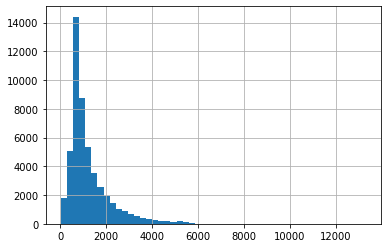

In [23]:
#analysis of number of characters in a review
df['review'].str.len().hist(bins=50)

In [24]:
df1=df['review'].str.split()

<AxesSubplot:>

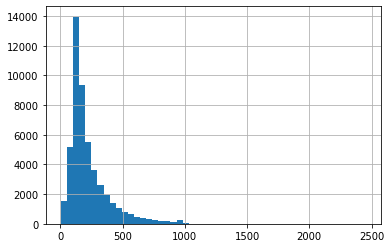

In [25]:
#analysis of number of words in a review
df1.str.len().hist(bins=50)

In [26]:
df_negative=df[df.sentiment=='negative']
df_negative.head()

,review,sentiment
3,basically theres a family where a little boy j...,negative
7,this show was an amazing fresh innovative idea...,negative
8,encouraged by the positive comments about this...,negative
10,phil the alien is one of those quirky films wh...,negative
11,i saw this movie when i was about 12 when it c...,negative


In [27]:
df_positive=df[df.sentiment=='positive']
df_positive.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
4,petter matteis love in the time of money is a ...,positive
5,probably my alltime favorite movie a story of ...,positive


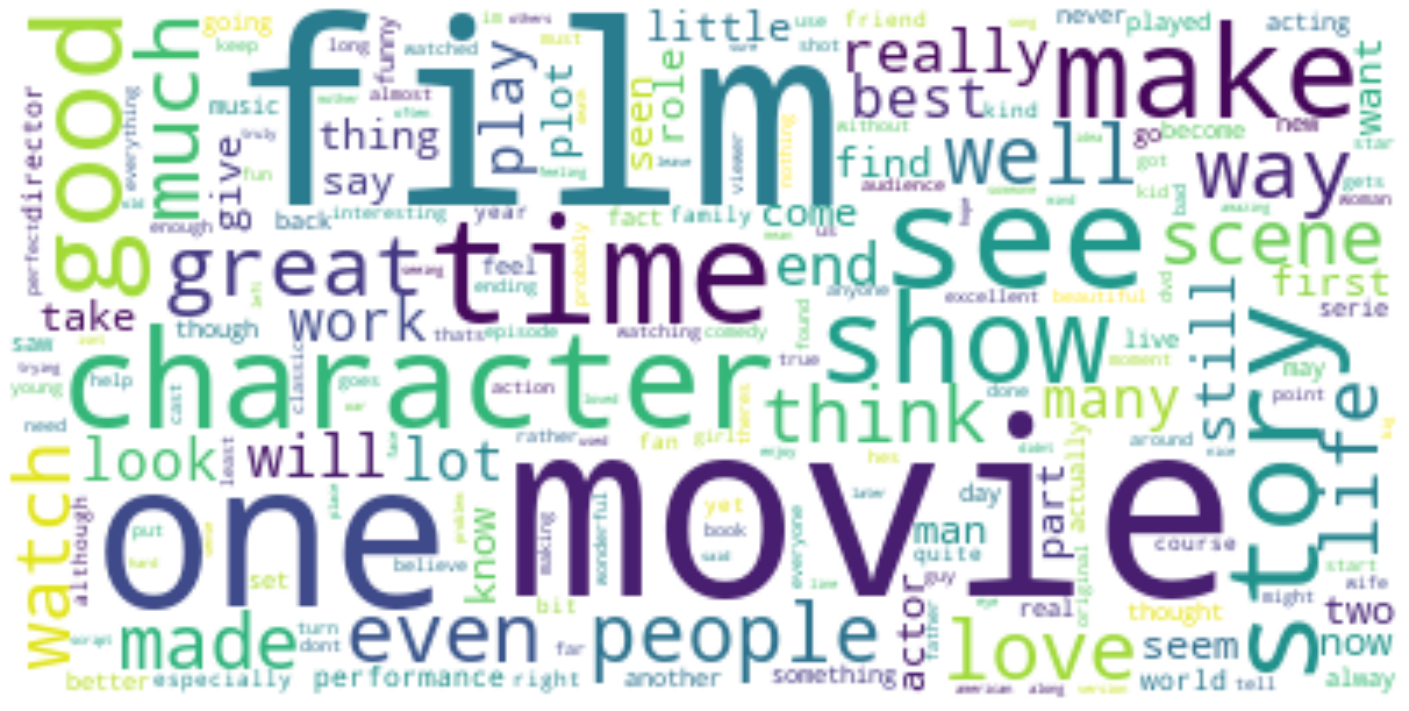

In [28]:
#visualisation of positive sentiments
text_positive= " ".join(i for i in df_positive.review)
stopwords = set(STOPWORDS)
wordcloud_positive = WordCloud(stopwords=stopwords, background_color="white").generate(text_positive)
plt.figure( figsize=(25,20))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis("off")
plt.show()

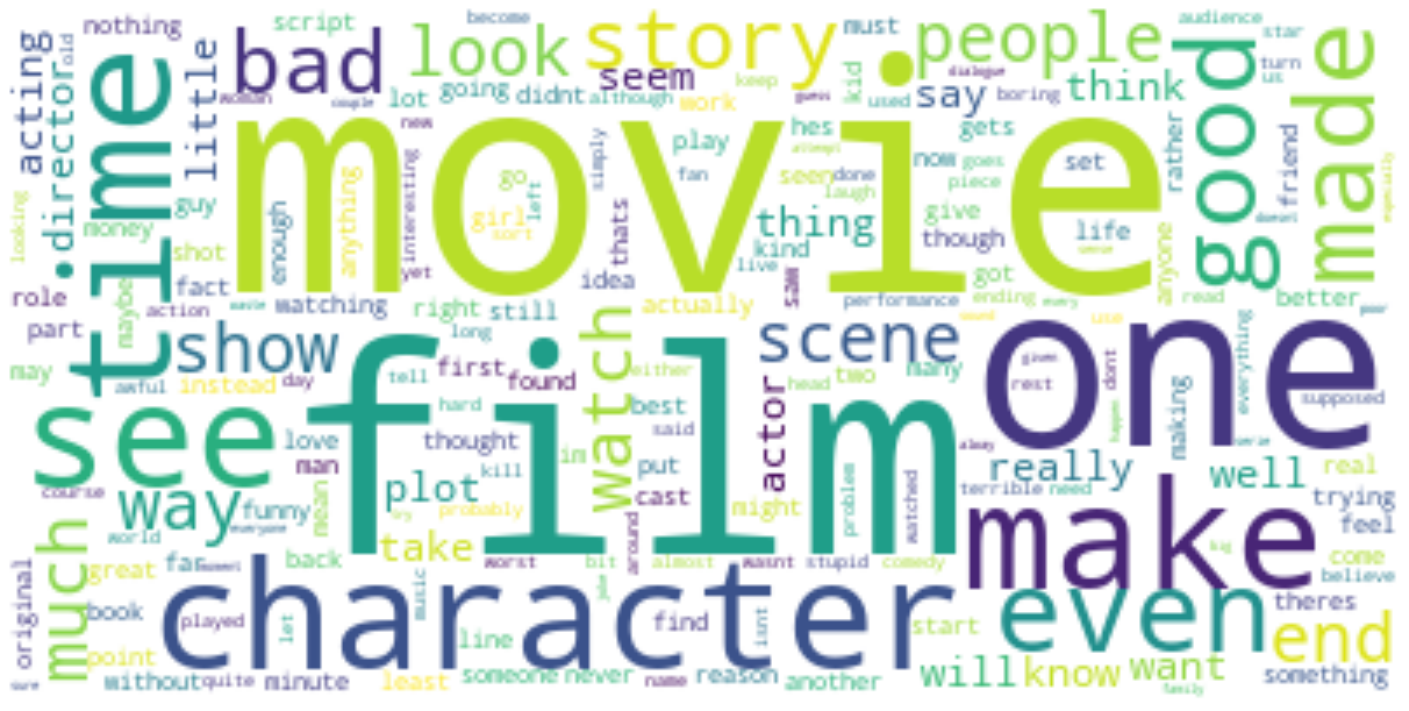

In [29]:
#visualisation of negative sentiments
text_negative= " ".join(i for i in df_negative.review)
stopwords = set(STOPWORDS)
wordcloud_negative = WordCloud(stopwords=stopwords, background_color="white").generate(text_negative)
plt.figure( figsize=(25,20))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off")
plt.show()

In [30]:
ps=PorterStemmer()

In [31]:
def stem(text):
    L=[]
    for i in text.split():
        L.append(ps.stem(i))
        
        
    string=" ".join(L)    
    return string

In [32]:
#applying stemming
df.review=df.review.apply(stem)

In [33]:
df['sentiment']=df['sentiment'].apply(lambda x: 1 if x=='positive' else 0)

In [34]:
df.head(10)

,review,sentiment
0,one of the other review ha mention that after ...,1
1,a wonder littl product the film techniqu is ve...,1
2,i thought thi wa a wonder way to spend time on...,1
3,basic there a famili where a littl boy jake th...,0
4,petter mattei love in the time of money is a v...,1
5,probabl my alltim favorit movi a stori of self...,1
6,i sure would like to see a resurrect of a up d...,1
7,thi show wa an amaz fresh innov idea in the 70...,0
8,encourag by the posit comment about thi film o...,0
9,if you like origin gut wrench laughter you wil...,1


In [35]:
#using tf-idf approach to vectorize
tfd=TfidfVectorizer(ngram_range=(1,3),max_features=5000)

In [36]:
vector=tfd.fit_transform(df.review)

In [37]:
vector=vector.toarray()
vector

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [38]:
vector.shape

(50000, 5000)

In [39]:
X_train=vector[0:40000]
Y_train=df.sentiment[0:40000]
X_test=vector[40000:]
Y_test=df.sentiment[40000:]

The accuracy of the model is:  88.7
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      4993
           1       0.89      0.89      0.89      5007

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



<AxesSubplot:>

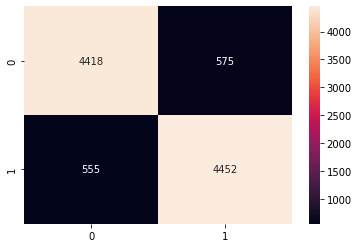

In [40]:
#logistic regression
model_lr=LogisticRegression()
model_lr.fit(X_train,Y_train)
print("The accuracy of the model is: ", model_lr.score(X_test,Y_test)*100)
predictions_lr=model_lr.predict(X_test)
print(classification_report(Y_test,predictions_lr))
cm=confusion_matrix(Y_test,predictions_lr)
sns.heatmap(cm,annot=True,fmt='d')

In [41]:
#random forest
model_rf=RandomForestClassifier(n_estimators=100)

In [42]:
model_rf.fit(X_train,Y_train)

RandomForestClassifier()

The accuracy of the model is:  84.50999999999999
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      4993
           1       0.85      0.85      0.85      5007

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



<AxesSubplot:>

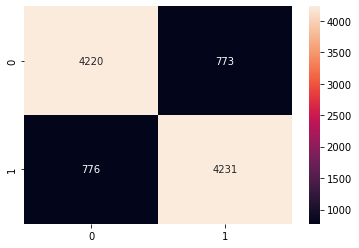

In [44]:
print("The accuracy of the model is: ", model_rf.score(X_test,Y_test)*100)
predictions_rf=model_rf.predict(X_test)
print(classification_report(Y_test,predictions_rf))
cm=confusion_matrix(Y_test,predictions_rf)
sns.heatmap(cm,annot=True,fmt='d')